# Summaries
the idea is to use summaries for each teime series,
pros:
- less features
- easy to compute

cons:
- breaking the time dependency

In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import scipy.stats as sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
df_train = pd.read_csv('data\\train.csv')
# df_train.to_parquet('train.parquet')
# df_train = pd.read_parquet('train.parquet')
df_ts = df_train.iloc[:,5:] # timeseries features only
df_train['y_s'] = df_train.y > 1 # simplified y: label 0 for 1 and 1 for 2,3 
df_train


,id,main.pos,fun.pos,when,y,E1A1,E1A2,E1A3,E1A4,E1A5,...,M2V2040,M2V2041,M2V2042,M2V2043,M2V2044,M2V2045,M2V2046,M2V2047,M2V2048,y_s
0,1,LHCB-P18,QSCB-18-C2,2017-06,1,-0.576589,-0.951065,0.944338,-0.086406,0.253089,...,-0.101842,0.027109,0.168339,0.152390,0.000410,-0.126250,0.072403,0.214993,0.184996,False
1,2,LHCB-6,QSCB-6-CP6,2018-09,1,0.970694,1.524991,1.813341,0.447012,-1.038631,...,-0.057328,-0.146602,0.069251,0.351492,0.106101,0.192691,0.167834,-0.170475,-0.236751,False
2,3,LHCB-8,QSCB-8-CP7,2022-11,1,1.065262,0.461292,0.416869,0.460564,-0.019386,...,-0.044788,0.011786,-0.037881,-0.152690,-0.104267,0.037444,0.489454,0.268134,-0.117367,False
3,4,LHCB-8,QSCB-8-CP1,2023-04,1,-0.341942,0.614190,0.904430,0.727268,0.187494,...,-0.071131,0.067982,-0.023509,-0.028273,0.000943,-0.018128,0.013366,0.015902,0.043247,False
4,5,LHCB-P18,QSCB-18-C1,2017-04,1,-0.569563,0.368497,-0.269832,-0.179988,-0.065328,...,0.105978,0.020868,0.173724,-0.037431,0.147695,0.038233,-0.047549,0.101227,-0.109760,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,1012,LHCB-4,QSCB-4-CP1,2019-03,1,-0.094653,-0.273495,0.927676,-0.244089,0.394102,...,-0.017458,0.113222,0.081531,-0.118022,-0.068159,-0.160683,-0.054098,-0.043842,0.079474,False
659,1013,LHCB-6,QSCB-6-CP1,2022-05,1,-0.447106,-0.074231,0.331543,0.150676,-0.050445,...,0.240015,0.169615,0.068595,0.097196,-0.020113,-0.010522,0.063634,0.096408,-0.085637,False
660,1014,LHCB-P18,QSCB-18-C2,2018-04,1,0.264532,1.554129,-1.447155,0.442756,2.655931,...,0.087096,-0.399536,-0.121802,-0.027615,-0.190010,-0.099357,-0.026138,-0.008852,-0.108788,False
661,1015,LHCB-4,QSCB-4-CP7,2017-01,1,-0.522473,-0.007026,0.361770,-0.630256,-0.851504,...,-0.215720,-0.006428,0.037543,0.120194,0.155707,0.156359,0.280801,0.155129,0.176686,False


In [42]:
df_train[df_train.y == 2]

,id,main.pos,fun.pos,when,y,E1A1,E1A2,E1A3,E1A4,E1A5,...,M2V2040,M2V2041,M2V2042,M2V2043,M2V2044,M2V2045,M2V2046,M2V2047,M2V2048,y_s
45,71,LHCB-6,QSCB-6-CP2,2018-05,2,-0.019961,0.360694,0.793256,1.017966,-0.108301,...,0.069634,-0.065539,-0.162668,-0.010467,-0.076620,-0.157719,0.049147,-0.012327,-0.025316,True
52,82,LHCB-6,QSCB-6-CP2,2018-12,2,0.074291,0.071821,0.137672,-0.192335,0.159581,...,0.060101,0.012269,-0.018523,-0.034849,-0.071711,0.017933,0.024581,0.068732,0.064189,True
71,108,LHCB-4,QSCB-4-CP2,2020-09,2,-1.923729,-0.233395,-0.930188,-0.334518,0.268439,...,0.004535,0.004462,-0.290558,-0.531270,-0.338329,-0.067551,0.095053,-0.309445,-0.024472,True
72,109,LHCB-6,QSCB-6-CP2,2019-03,2,0.166958,0.365584,0.154854,-0.038091,0.005492,...,0.021394,0.109818,0.004095,-0.041422,0.003012,-0.054276,0.048111,-0.013782,0.107738,True
73,116,LHCB-P18,QSCB-18-C2,2023-05,2,2.087661,2.080400,0.723543,0.283793,-0.424942,...,0.064176,0.426887,-0.598271,0.072462,0.079344,-0.371225,0.485529,-0.088271,-0.424179,True
81,125,LHCB-6,QSCB-6-CP2,2018-08,2,0.017039,0.207033,0.135353,-0.250860,-0.514325,...,-0.111242,-0.037382,0.094073,-0.027791,0.104661,0.082808,0.050501,0.082094,0.028327,True
88,141,LHCB-8,QSCB-8-CP6,2017-09,2,0.180657,-0.254425,-0.014598,-0.006113,0.014820,...,0.018814,-0.150168,0.012154,-0.275922,-0.522704,-0.362488,-0.171049,0.031090,-0.213796,True
133,208,LHCB-8,QSCB-8-CP2,2020-08,2,-0.144582,-0.130243,0.715936,0.677207,0.234826,...,0.072802,0.220041,0.188067,0.070265,0.052819,0.010355,0.139053,0.222614,0.118270,True
147,228,LHCB-8,QSCB-8-CP6,2017-06,2,1.068565,1.332568,0.882897,1.182927,-0.105541,...,0.002651,0.141693,-0.065041,-0.251389,-0.240337,0.153641,-0.043423,-0.019266,-0.005078,True
160,252,LHCB-8,QSCB-8-CP6,2020-08,2,-1.038094,-0.134487,0.490120,-0.043800,-0.170746,...,-0.152073,0.204889,-0.357757,-0.144058,-0.134319,0.121635,0.293264,0.066293,-0.075689,True


In [74]:
df_train.columns

Index(['id', 'main.pos', 'fun.pos', 'when', 'y', 'E1A1', 'E1A2', 'E1A3',
       'E1A4', 'E1A5',
       ...
       'M2V2040', 'M2V2041', 'M2V2042', 'M2V2043', 'M2V2044', 'M2V2045',
       'M2V2046', 'M2V2047', 'M2V2048', 'y_s'],
      dtype='object', length=49158)

In [106]:
diff = lambda x: x[-256:].mean() - x[:256].mean()


(3.939138780675017e-05, 3.87580511289144e-05, 0.08091165206860751)

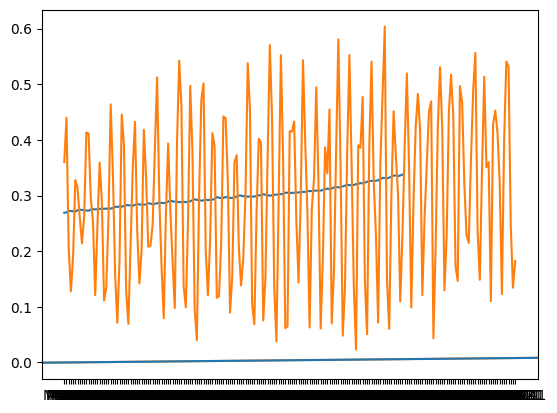

In [119]:
ts = df_ts.iloc[45, 18*2048:19*2048]

lin = summaries['slope'](ts)
ts_s = np.convolve(ts, np.ones(512)/512, mode='valid')
lin_s = sp.linregress(np.arange(0,ts_s.shape[0],1), ts_s).slope
plt.plot(ts_s[4::10])
plt.plot(ts[::10])
plt.axline((0, 0), slope=lin, color='C1', label='by slope')
plt.axline((0, 0), slope=lin_s, color='C0', label='b')
lin, lin_s, diff(ts)

(-7.489858488735235e-06, -8.689697548411458e-05, -0.010123650003151824)

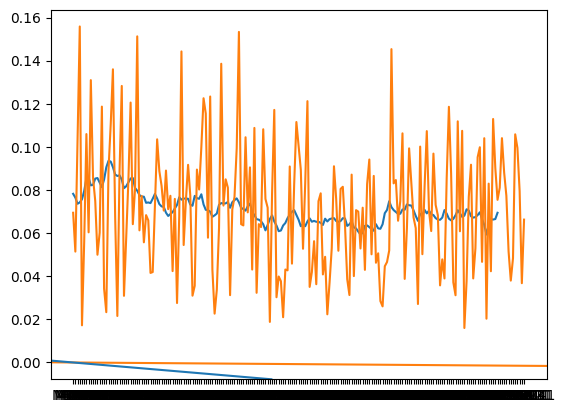

In [118]:
ts = df_ts.iloc[3, 18*2048:19*2048]

lin = summaries['slope'](ts)
ts_s = np.convolve(ts, np.ones(128)/128, mode='valid')
lin_s = sp.linregress(np.arange(0,ts_s.shape[0]/10,1), ts_s[::10]).slope
plt.plot(ts_s[::10])
plt.plot(ts[::10])
plt.axline((0, 0), slope=lin, color='C1', label='by slope')
plt.axline((0, 0), slope=lin_s, color='C0', label='b')
lin, lin_s, diff(ts)

In [48]:
sp.linregress(np.arange(0,2048,1), ts)

LinregressResult(slope=3.939138780675017e-05, intercept=0.25968177096951167, rvalue=0.1556902771827657, pvalue=1.3936842857784114e-12, stderr=5.5253348215383736e-06, intercept_stderr=0.00653083707453761)

In [124]:
import scipy.stats as sp


summaries = {
    'max': np.max,
    'min': np.min,
    'mean': np.mean,
    # 'q01': lambda x: np.quantile(x, q=0.01),
    # 'q05': lambda x: np.quantile(x, q=0.05),
    # 'q25': lambda x: np.quantile(x, q=0.25),
    'median': np.median,
    # 'q75': lambda x: np.quantile(x, q=0.75),
    # 'q95': lambda x: np.quantile(x, q=0.95),
    # 'q99': lambda x: np.quantile(x, q=0.99),
    # 'sd' : np.std,
    'var': np.var,
    'slope': lambda x: np.arctan(sp.linregress(np.arange(0,x.shape[0],1), x).slope),
    'diff' :  lambda x: x[-256:].mean() - x[:256].mean(),
    # 'kurtosis': sp.kurtosis,
    # 'trim_mean': lambda x: sp.trim_mean(x, 0.25),
}

from util import apply_summaries
X = apply_summaries(df_ts, summaries)
X


,max_E1A,max_E1H,max_E1P,max_E1V,max_E2A,max_E2H,max_E2P,max_E2V,max_E3A,max_E3H,...,diff_E4P,diff_E4V,diff_M1A,diff_M1H,diff_M1P,diff_M1V,diff_M2A,diff_M2H,diff_M2P,diff_M2V
0,3.106584,12.067687,19.177058,2.904495,2.064329,7.027072,6.340742,2.982987,3.890517,14.949150,...,0.232149,-0.035800,-0.002967,0.006149,-0.024737,-0.011681,0.001346,0.013800,0.002259,-0.012423
1,1.973324,3.334162,3.230021,2.075948,2.325271,3.196759,3.119100,2.203837,2.168119,4.257831,...,0.105077,-0.012591,-0.007376,0.006047,-0.035703,0.001688,-0.000399,-0.004712,-0.021839,-0.007352
2,4.905155,3.816043,4.624890,1.912259,3.906155,4.914904,6.291021,3.556789,2.485419,5.553386,...,0.024935,-0.011589,0.001767,0.007561,-0.008706,-0.003920,-0.000116,0.001856,0.018002,0.001417
3,4.146159,12.211521,20.694593,1.946000,2.528676,12.353929,17.187908,1.648643,3.365520,19.111603,...,0.565530,-0.008314,-0.003409,0.001011,-0.010124,-0.000683,0.001315,-0.004370,-0.015956,-0.003470
4,2.507720,6.752539,6.668999,3.012293,2.204402,7.998847,8.025621,2.356230,2.283782,10.433940,...,-0.059491,0.023441,-0.000324,-0.001685,0.010066,0.000199,0.002951,0.000633,-0.005445,-0.003266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,2.627815,10.701584,12.654741,2.283455,2.531638,7.849816,6.931436,2.794771,2.605332,11.994953,...,-0.305541,-0.001968,-0.002239,0.005267,0.006127,-0.001606,0.000247,-0.000783,0.010322,0.003682
659,2.733922,4.979573,8.429594,3.103308,1.884466,7.571239,13.081043,1.217670,2.633123,6.707066,...,0.049787,-0.023415,-0.008297,-0.003120,0.000949,0.004070,-0.000992,0.000841,-0.013427,0.005366
660,4.631380,12.068901,14.897799,4.111245,2.937032,8.865655,13.798335,2.973656,10.616217,12.786204,...,-0.096720,-0.009967,0.003223,-0.001992,0.008634,-0.005317,-0.000466,-0.007098,-0.016357,-0.005142
661,2.340140,3.257143,9.396940,3.182236,4.438345,5.194028,5.873247,3.869224,3.320506,10.530150,...,-0.031597,0.012557,-0.002046,0.003342,-0.046218,-0.000121,-0.000143,0.004425,0.005107,-0.001381


C:\Users\laura\AppData\Local\Temp\ipykernel_16140\1139203814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['y'] = df_train.y_s
C:\Users\laura\AppData\Local\Temp\ipykernel_16140\1139203814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['y'] = df_train.y_s
C:\Users\laura\AppData\Local\Temp\ipykernel_16140\1139203814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

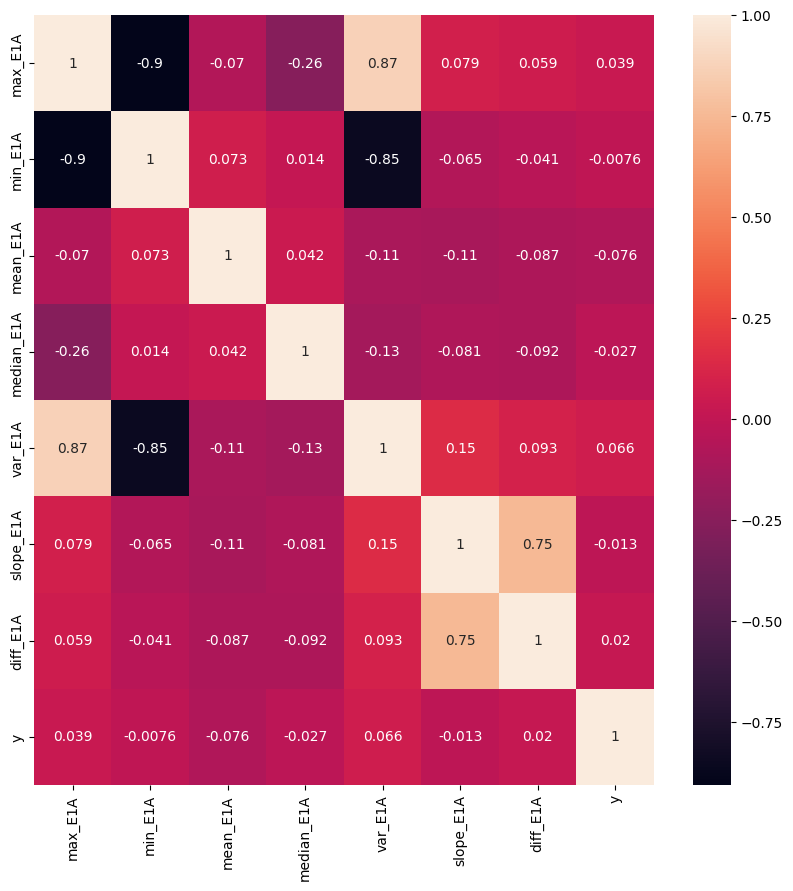

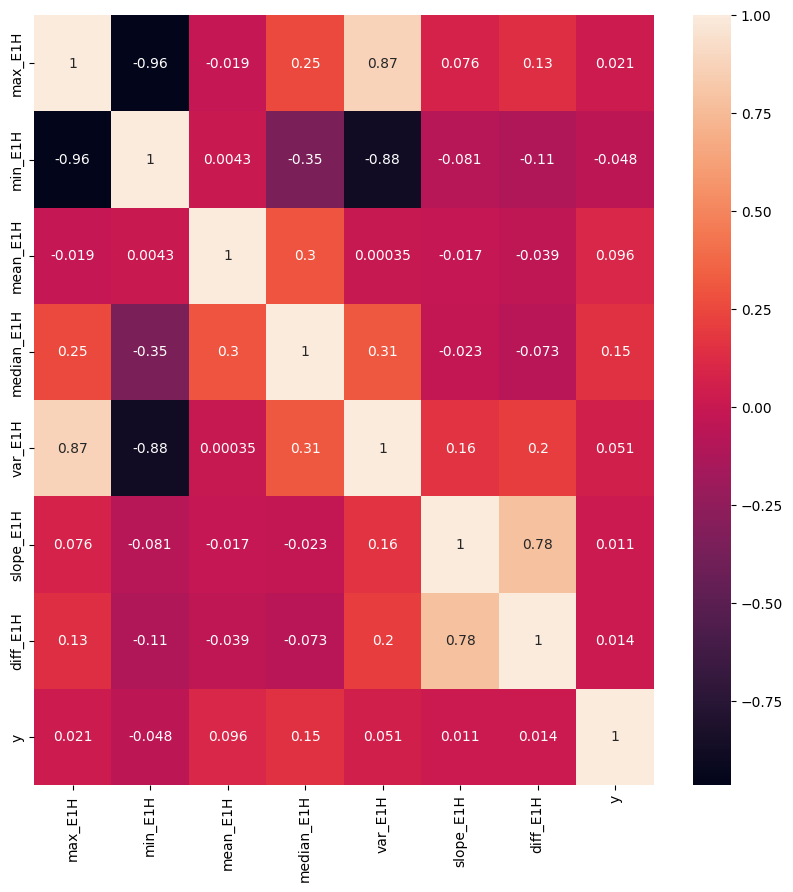

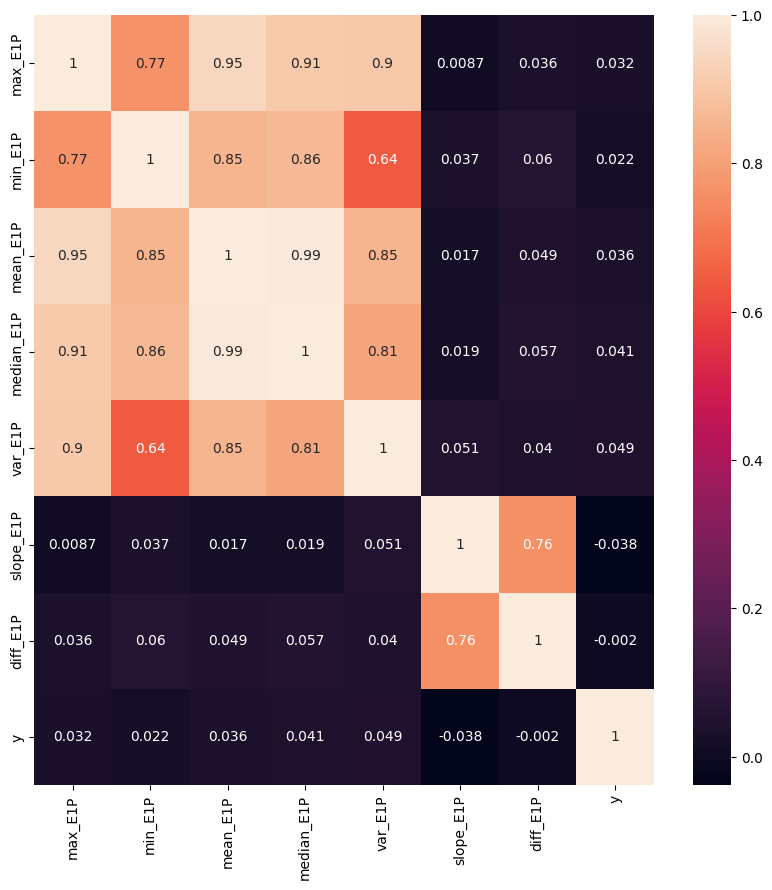

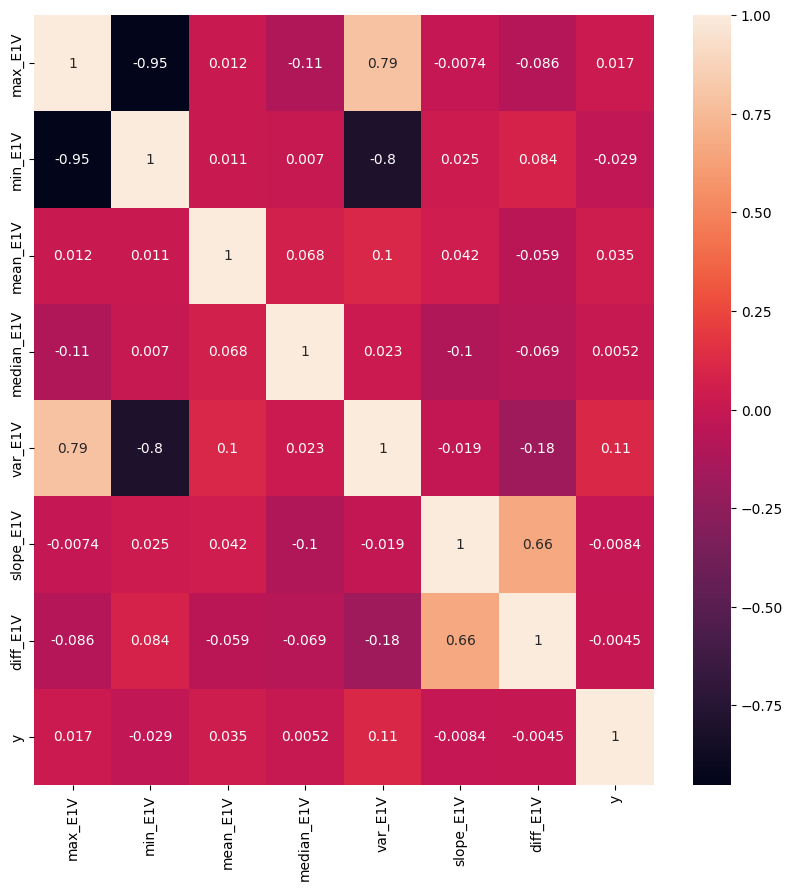

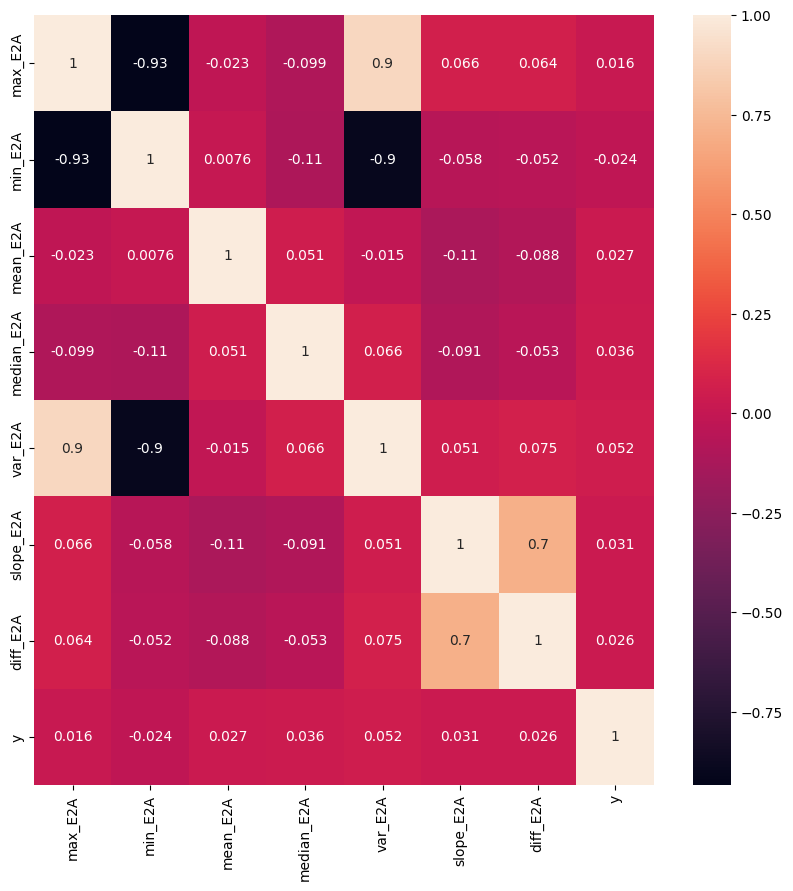

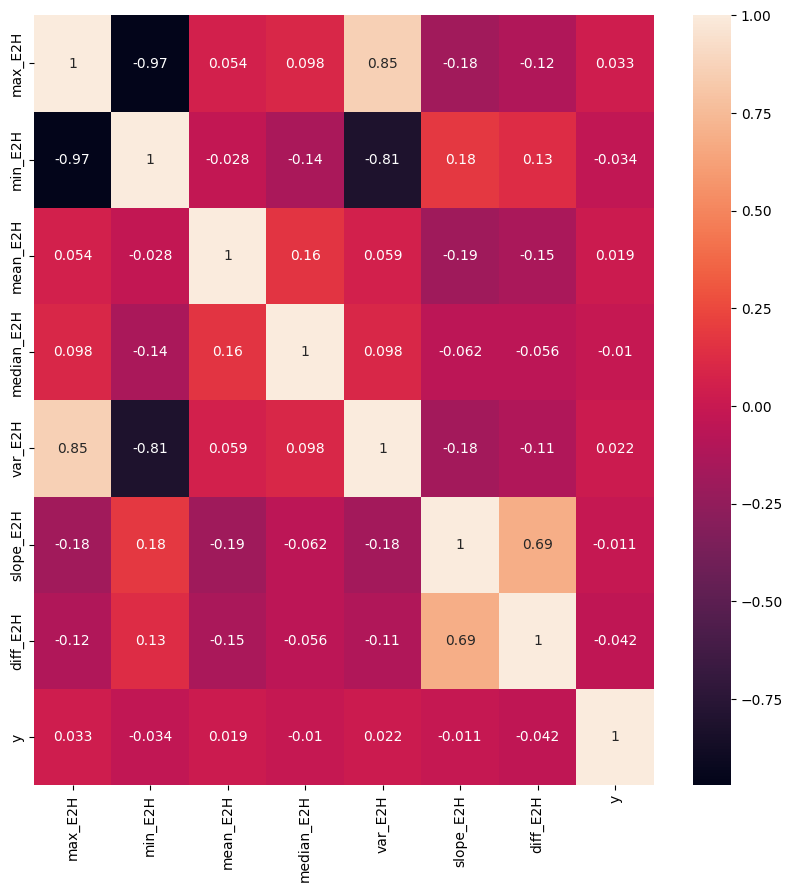

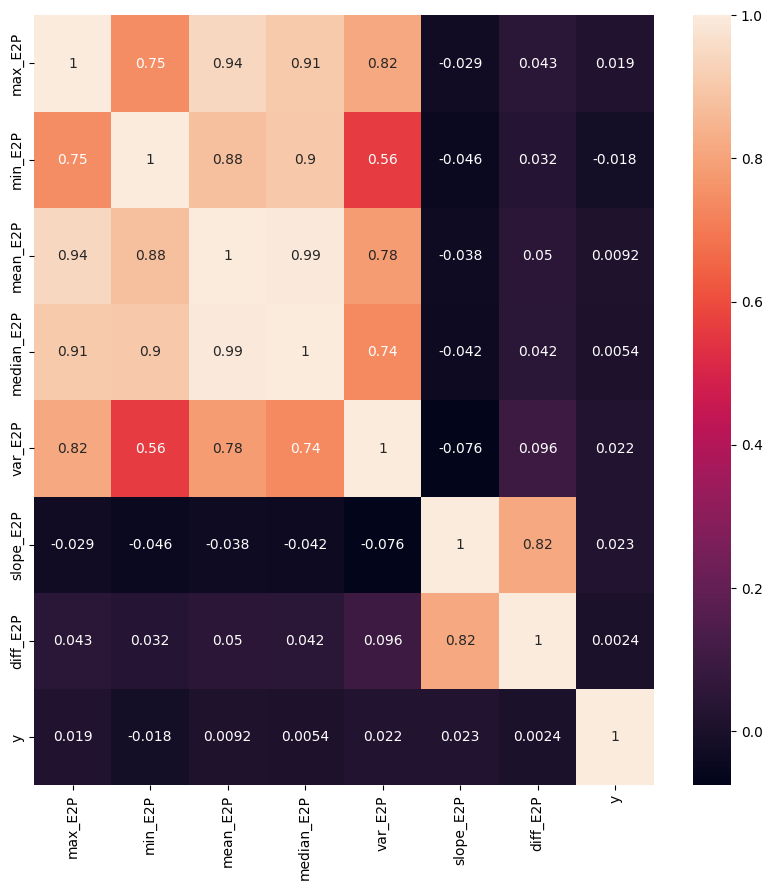

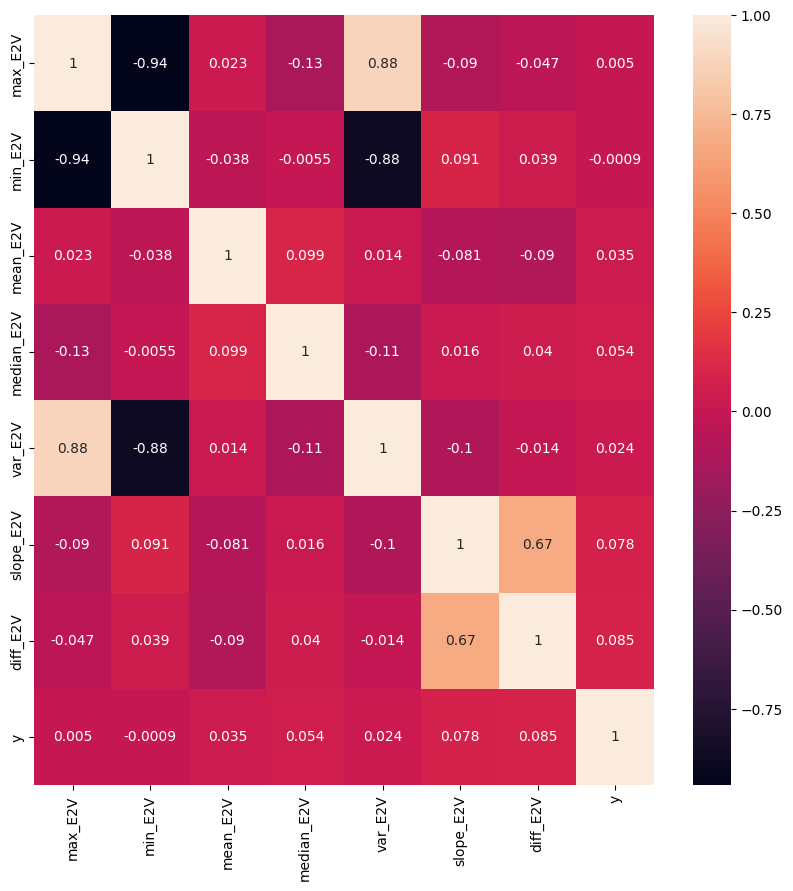

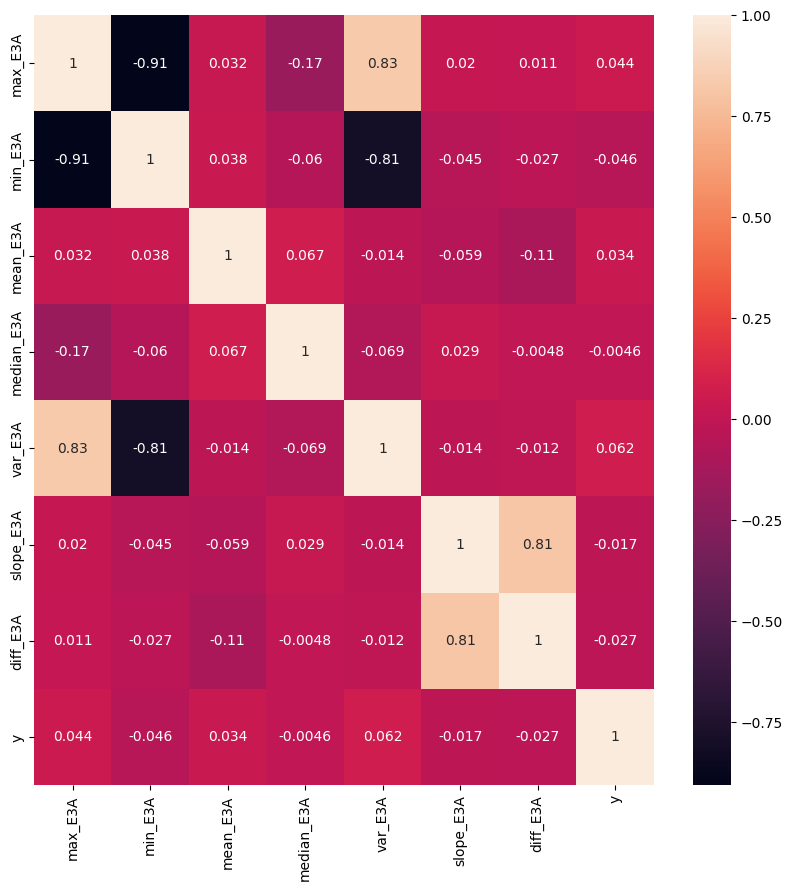

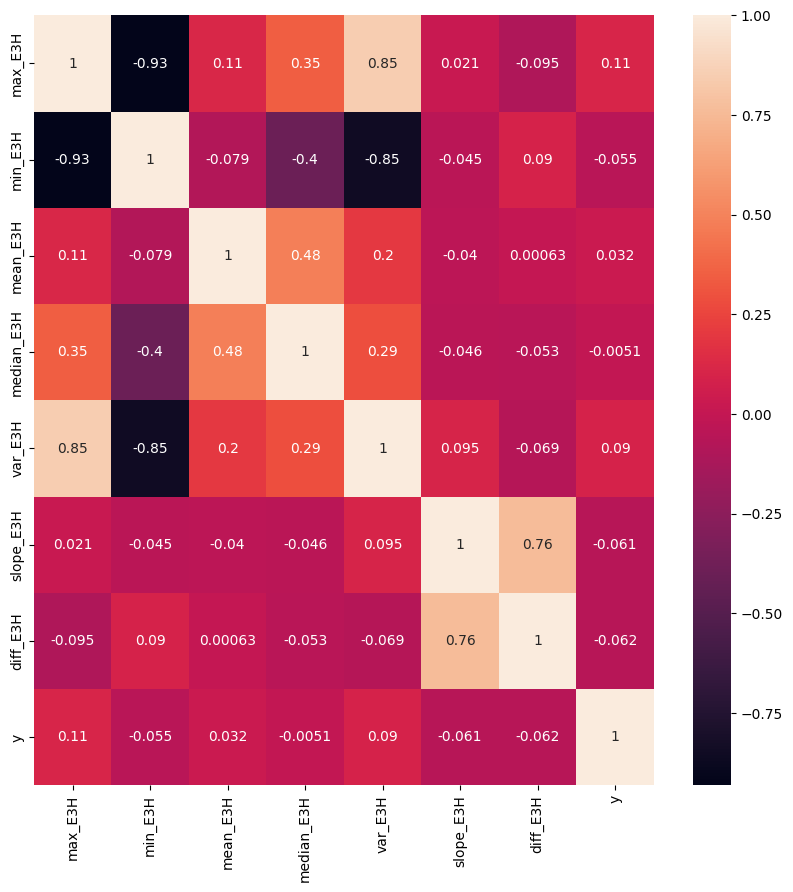

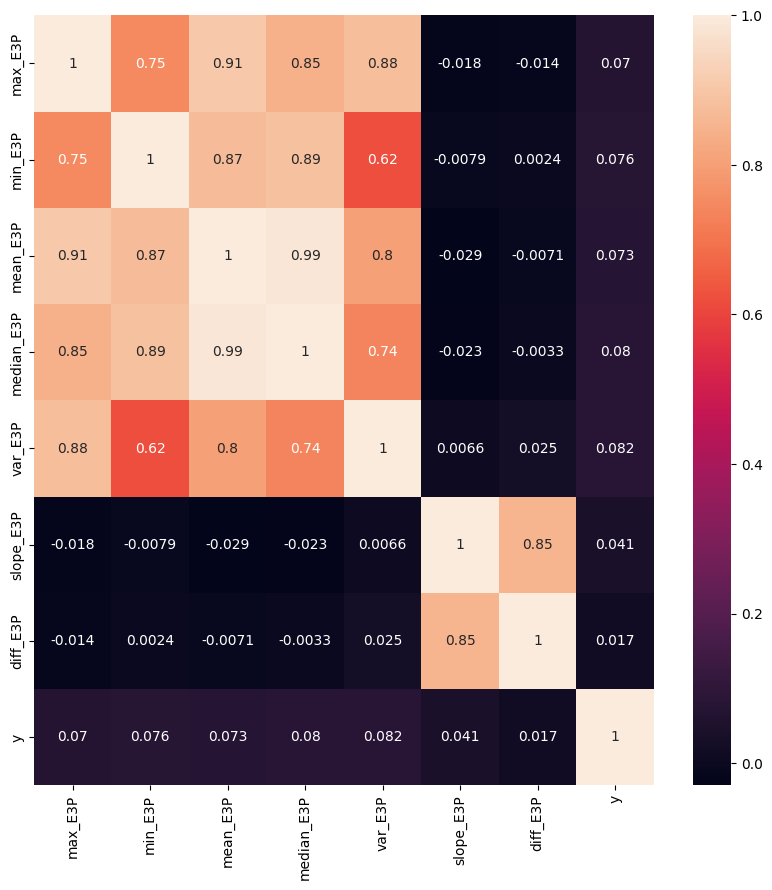

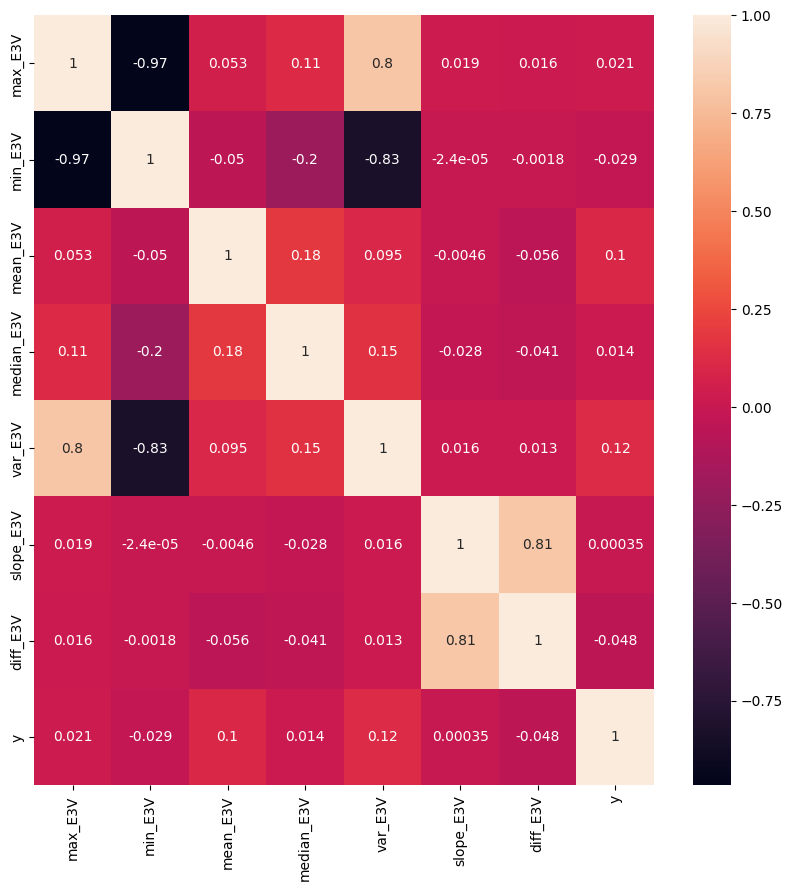

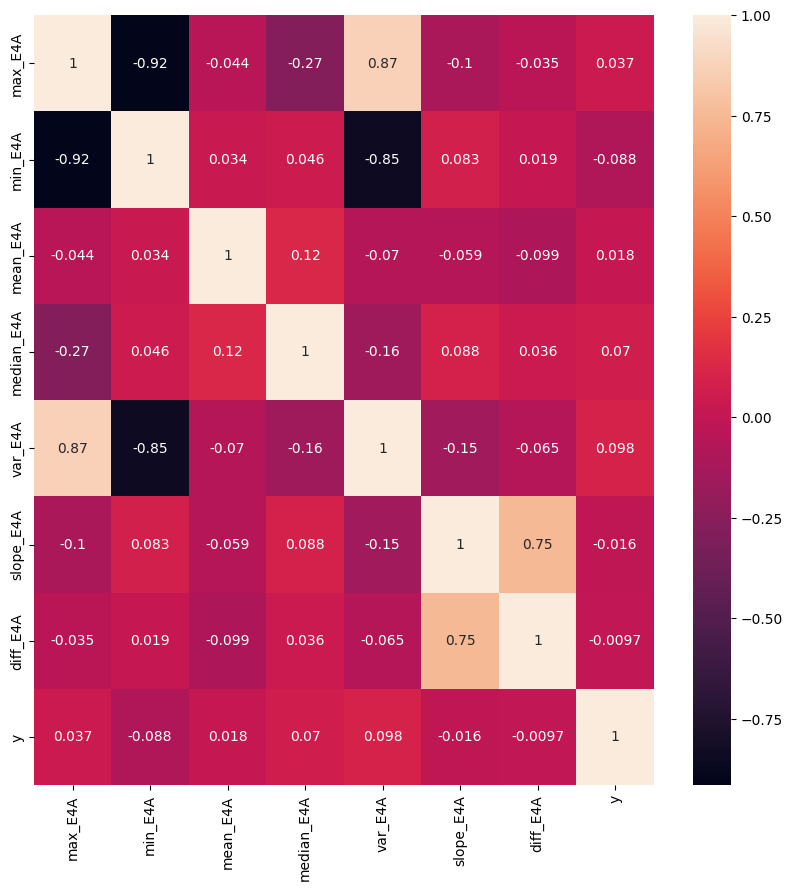

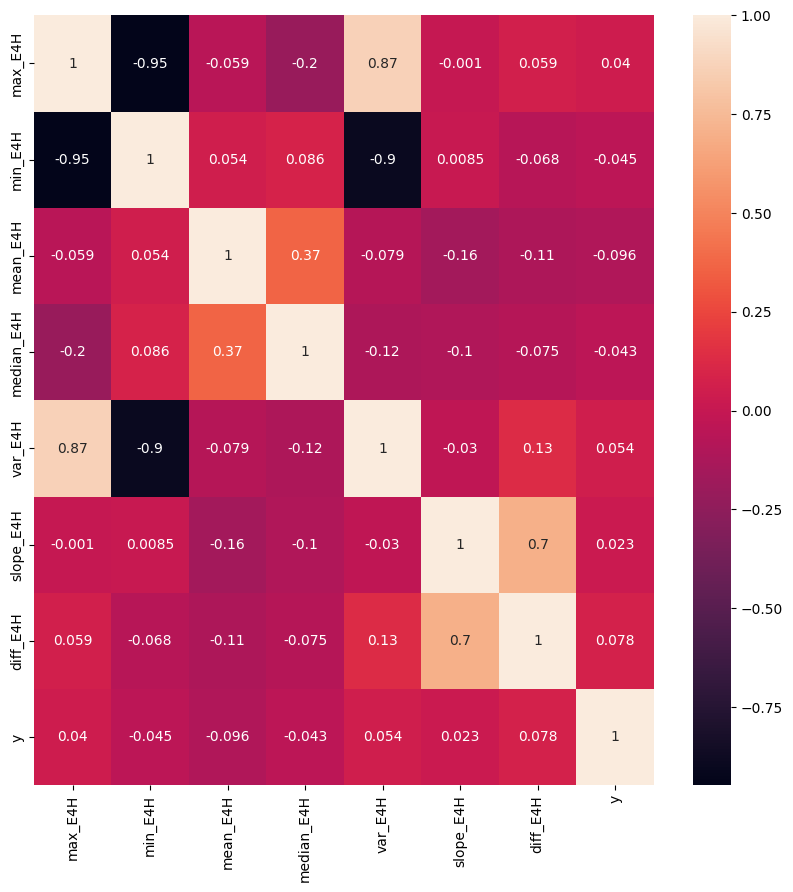

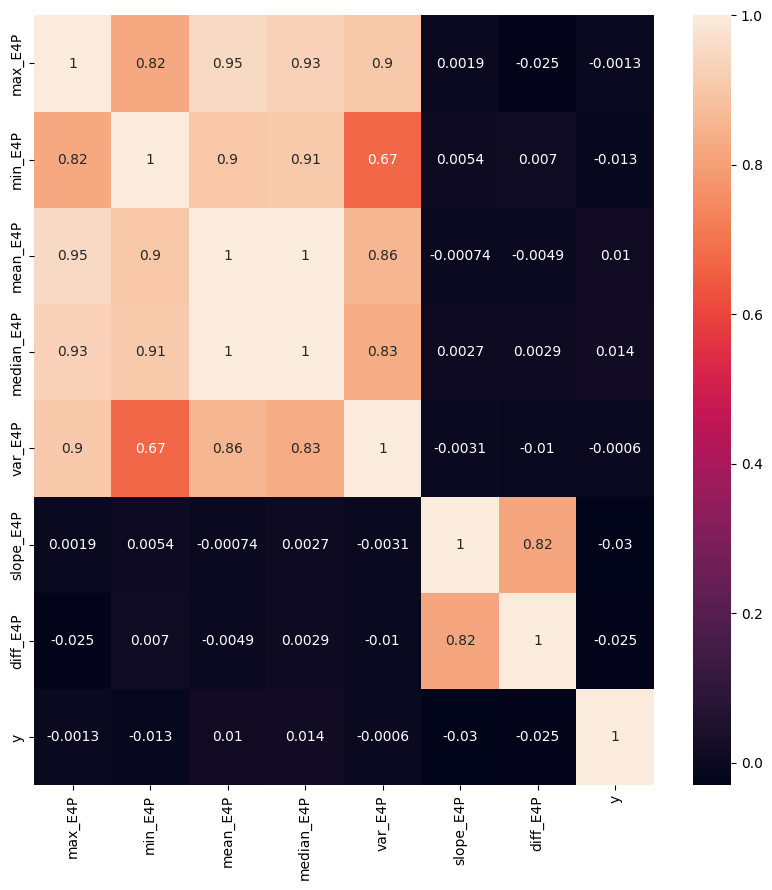

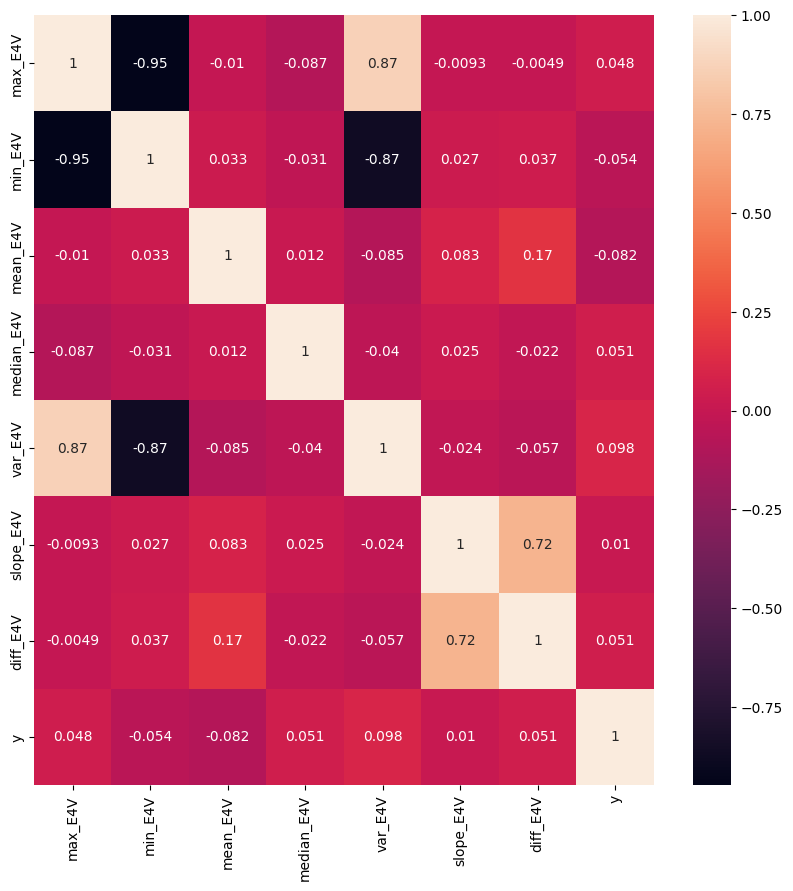

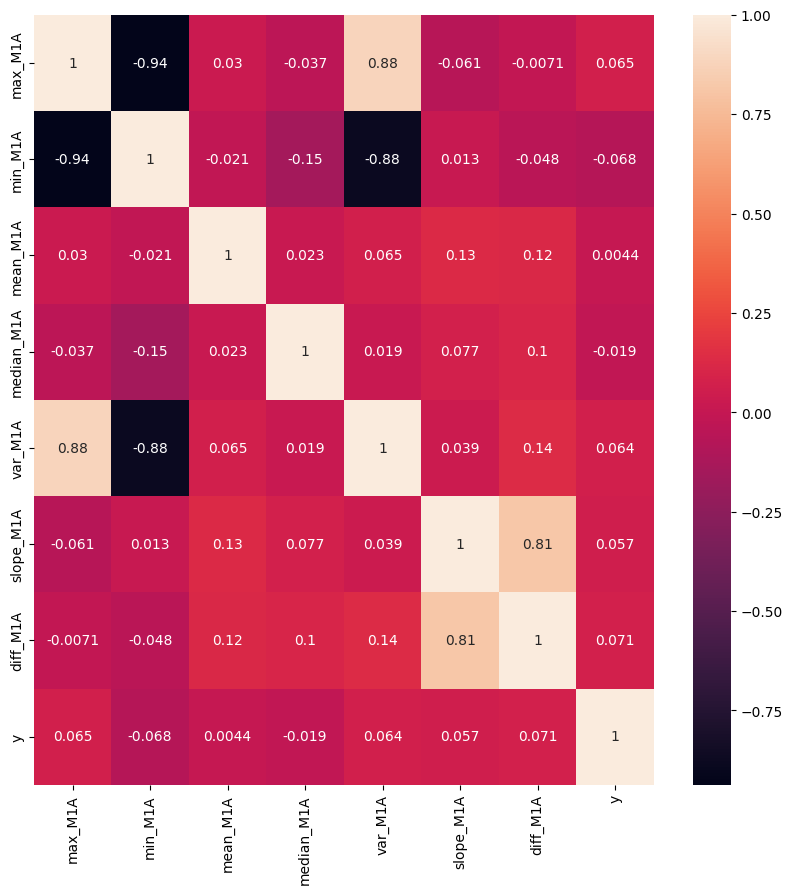

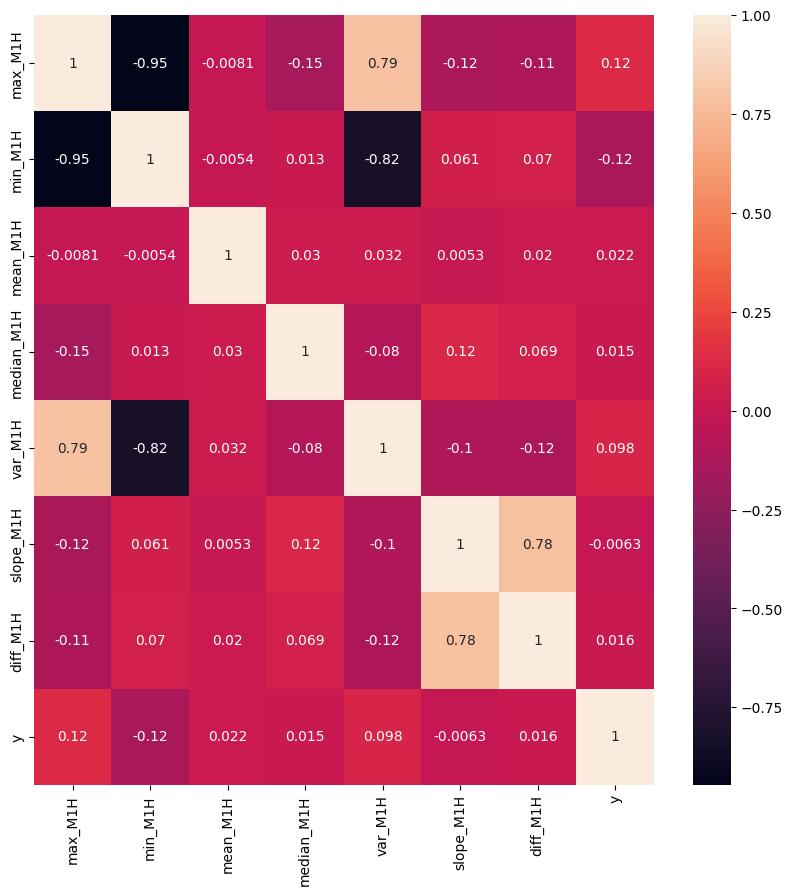

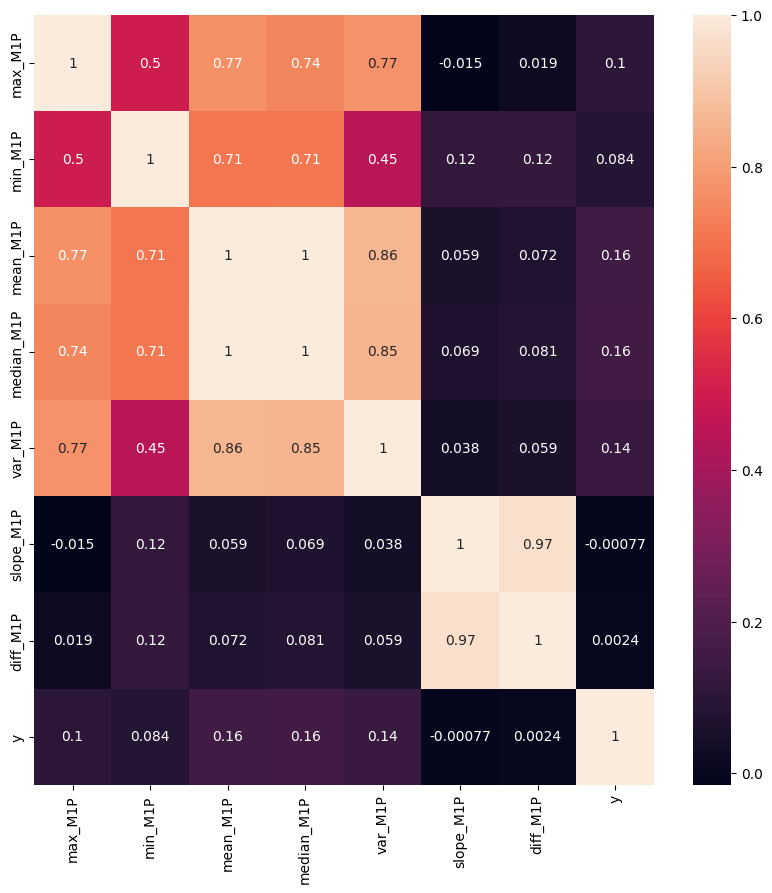

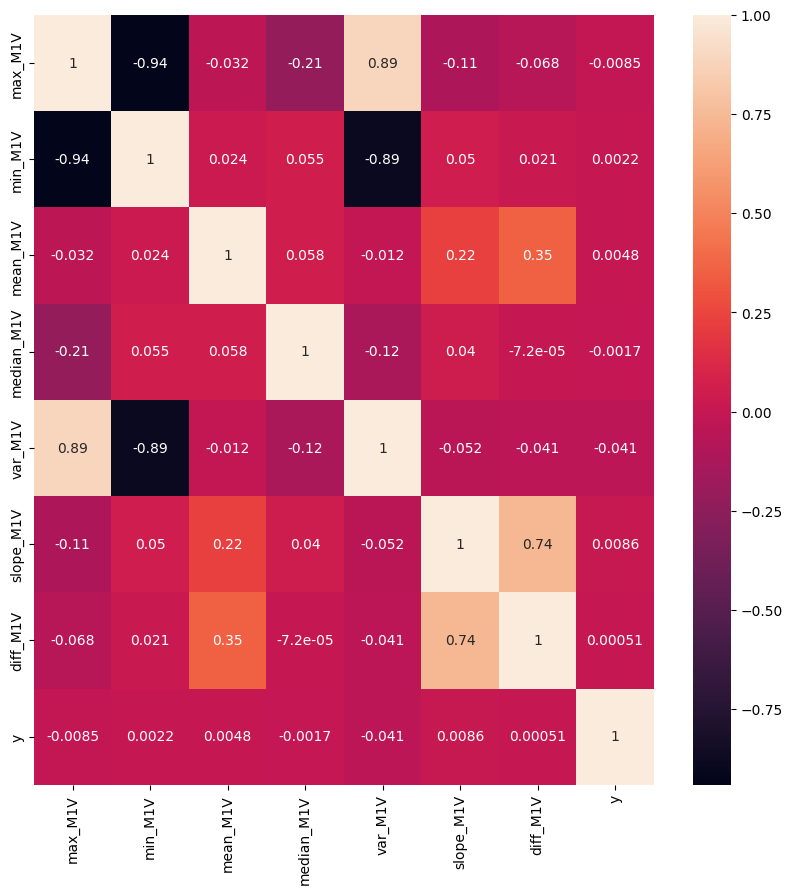

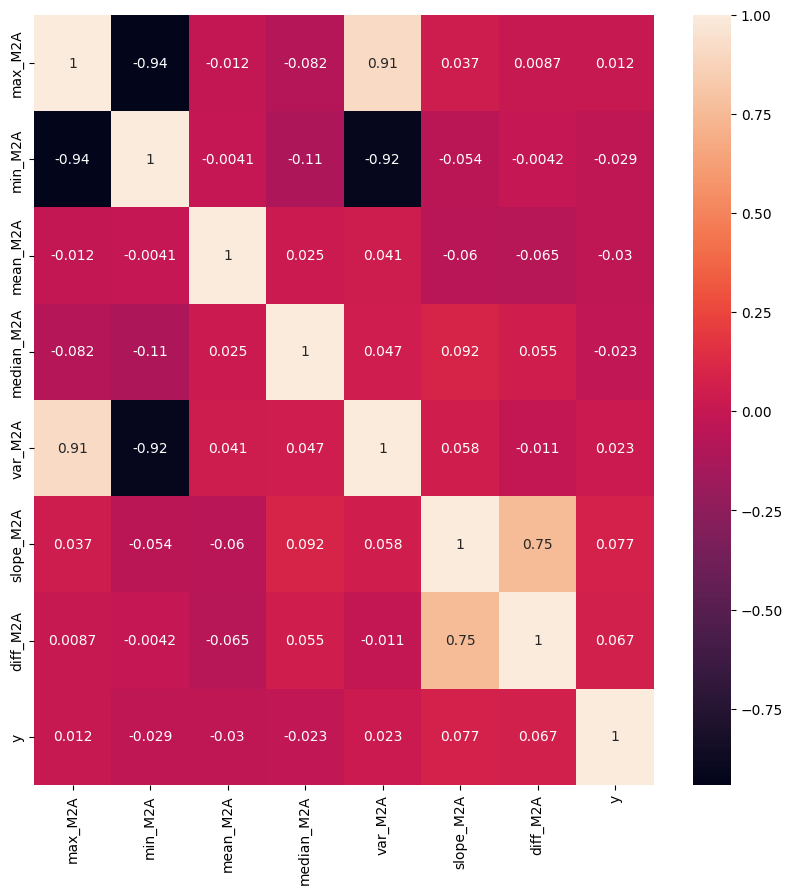

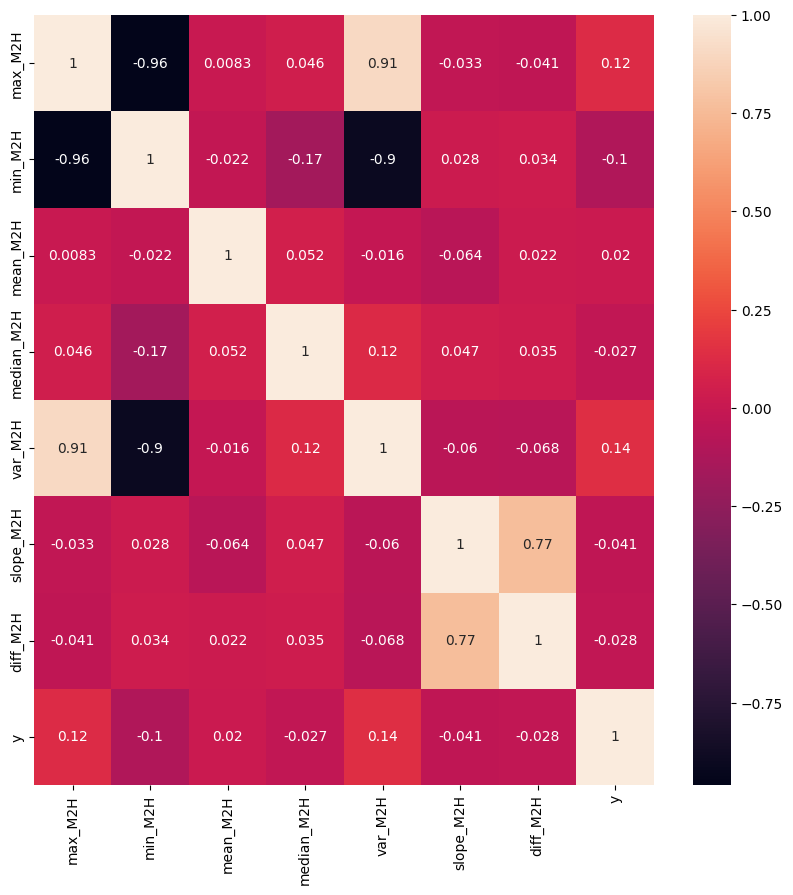

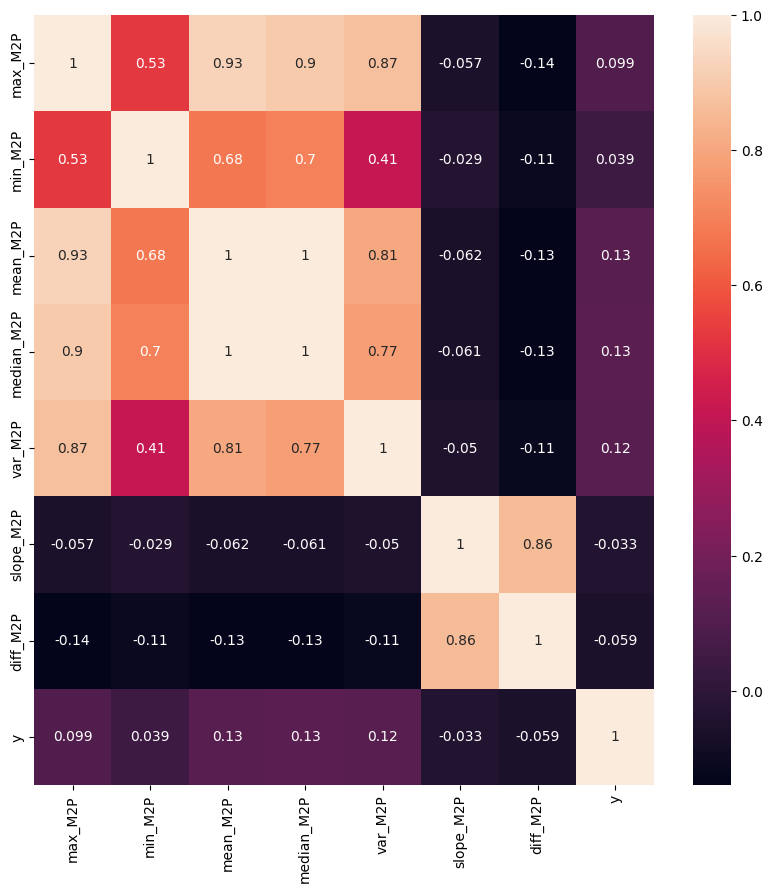

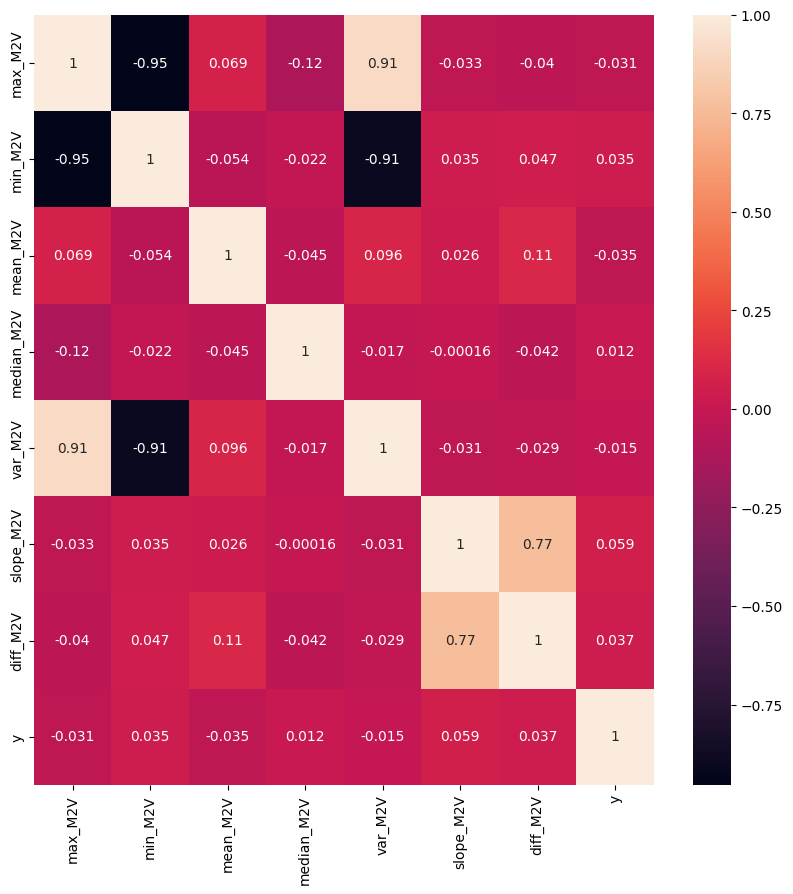

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in range(24):
    d = X.iloc[:,i::24]
    # d = pd.DataFrame(StandardScaler().fit_transform(d))
    d['y'] = df_train.y_s

    plt.figure(figsize=(10,10))
    sns.heatmap(d.corr(), annot=True)


## Model fit

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
x_train, x_test, y_train, y_test = train_test_split(X, df_train.y_s, test_size=0.3, stratify=df_train.y_s)
model = make_pipeline(
    # StandardScaler(),
    SVC(C=1, class_weight='balanced')
    )
model.fit(x_train,y_train)

Pipeline(steps=[('svc', SVC(C=1, class_weight='balanced'))])

(array([[117,  69],
        [ 10,   3]], dtype=int64),
 0.4299007444168734)

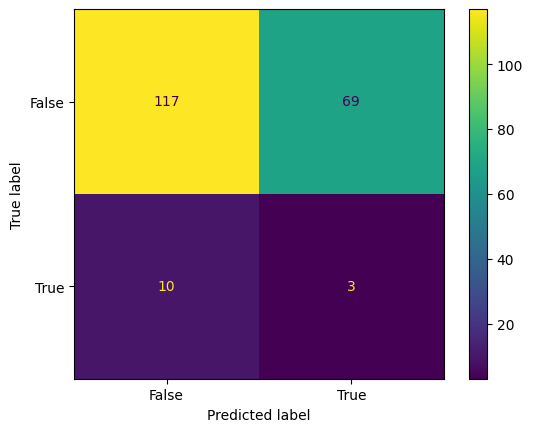

In [132]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay

y_hat = model.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)

confusion_matrix(y_test,y_hat),balanced_accuracy_score(y_test, y_hat)

## Cross-validation

In [183]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
model = OrdClass(SVC(class_weight='balanced', probability=True))
params = {'C' : np.linspace(0.1,3,40),
          'kernel':['poly','rbf','linear']}
skf = StratifiedKFold(n_splits=4)

In [201]:
from sklearn.ensemble import RandomForestClassifier

model = OrdClass(RandomForestClassifier(class_weight='balanced'))
params = {'n_estimators' : [100, 200, 500, 1000],
          'max_features':['sqrt', 'log2',X.columns.shape[0]]}
skf = StratifiedKFold(n_splits=4)

In [202]:
cv = GridSearchCV(
    model, 
    param_grid=params, 
    scoring='balanced_accuracy', 
    n_jobs=-1, 
    cv=skf.split(X, df_train.y)
)
cv.fit(X,df_train.y)

cv.best_params_, cv.best_score_

({'max_features': 'sqrt', 'n_estimators': 100}, 0.3333333333333333)

In [186]:
cv.best_estimator_.class_weight_

array([ 0.35645161,  5.66666667, 55.25      ])

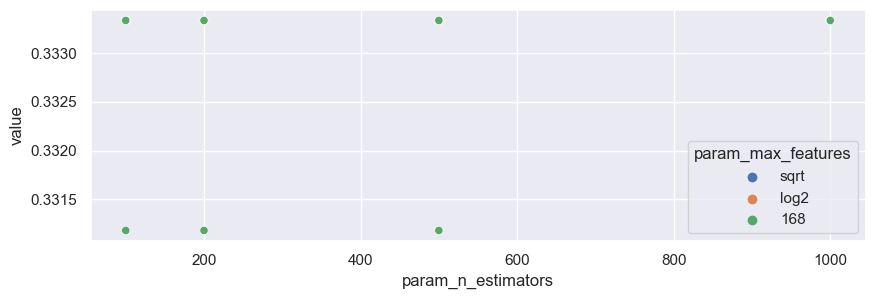

In [203]:
from util import plot_cv_results
# plot_cv_results(cv, 'param_C', 'param_kernel')
# plot_cv_results(cv, 'param_n_neighbors', 'param_weights')
plot_cv_results(cv, 'param_n_estimators', 'param_max_features')

In [204]:
y_hat = cv.predict(X)
confusion_matrix(df_train.y, y_hat),balanced_accuracy_score(df_train.y, y_hat)

(array([[620,   0,   0],
        [  0,  39,   0],
        [  0,   0,   4]], dtype=int64),
 1.0)

# Submission

In [165]:
model_final = cv
# model_final.fit(X, df_train.y)
df_sub = pd.read_csv('data\\test.csv')

In [168]:
X_sub = apply_summaries(df_sub.iloc[:,4:], funcs=summaries)
y_sub = model_final.predict(X_sub)

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

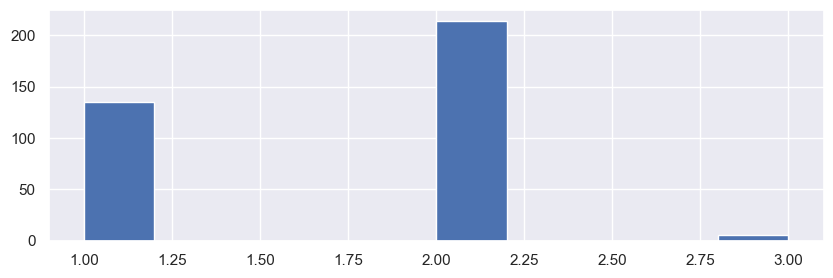

In [171]:
from datetime import datetime
y_sub = model_final.predict(X_sub)
plt.hist(y_sub)

submission_df = pd.DataFrame(y_sub,columns=['y'])
submission_df['id'] = df_sub.id
submission_df.set_index('id', inplace=True)
# submission_df.y = submission_df.y
submission_df.to_csv(f'data\\submissions\\summary_{datetime.now().strftime("%H.%M_%d")}.csv')